# TM10007 Assignment template

In [2]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!


In [3]:
import pandas as pd
# Data loading functions. Uncomment the one you want to use
# from worcgist.load_data import load_data
#from worclipo.load_data import load_data
from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
pd.DataFrame(data)

The number of samples: 186
The number of columns: 494


,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
ID,,,,,,,,,,,,,,,,,,,,,
Liver-001_0,benign,0.878471,0.023468,39.716446,4.650388,4.840280,3.599071,0.975855,0.008789,0.016611,...,0.000000,0.101850,2.616758,6.864153,0.0,0,0.390248,449.839556,0.007130,12.746479
Liver-002_0,benign,0.878945,0.039922,17.254964,2.741507,6.521991,2.687448,0.989684,0.006644,0.026773,...,0.000000,0.173083,1.553137,1.295746,0.0,0,0.594234,235.252263,0.187216,10.778987
Liver-003_0,benign,0.766162,0.064140,33.803937,7.191043,6.634326,3.101814,0.964987,0.020437,0.045053,...,0.084954,0.171358,1.032906,0.173105,0.0,0,0.582798,3163.278682,0.269640,14.878373
Liver-004_0,malignant,0.825737,0.062047,43.053826,5.973366,8.340360,4.981466,0.965802,0.016256,0.019045,...,0.000000,0.088297,3.265959,11.372725,0.0,0,0.362900,983.532471,0.000000,13.937997
Liver-005_0,malignant,0.828831,0.062635,28.420403,2.739982,5.531189,1.825404,0.946483,0.028237,0.009983,...,0.000000,0.133324,2.029068,3.703768,0.0,0,0.495562,294.506372,0.110388,11.764256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Liver-182_0,malignant,0.720708,0.077387,46.373175,9.300503,14.110627,7.885281,0.935700,0.028969,0.041396,...,0.000000,0.157149,1.390444,1.012183,0.0,0,0.541313,3310.717518,0.203399,15.035530
Liver-183_0,benign,0.784611,0.061993,16.636405,3.775585,12.142493,4.910086,0.986091,0.016373,0.059800,...,0.000000,0.138846,1.782002,2.440693,0.0,0,0.499997,380.507717,0.134518,12.087912
Liver-184_0,benign,0.811192,0.064007,38.940039,5.907410,9.460030,2.862713,0.958388,0.026688,0.024795,...,0.000000,0.124868,1.735833,2.393579,0.0,0,0.441963,1630.035114,0.131245,14.531357


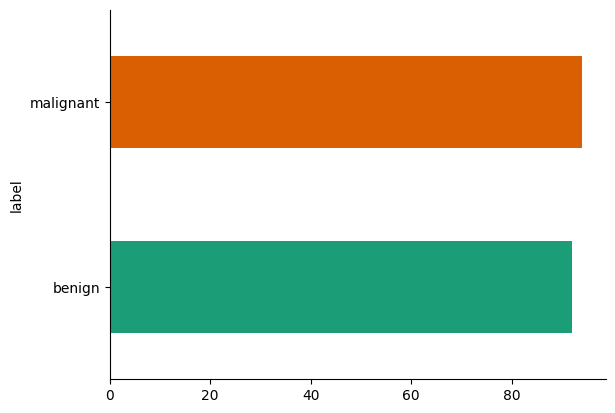

In [5]:
# Plot the devision of malignant and benign tumours
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)